In [33]:
import h5py
import numpy as np

In [34]:
from e2c_train import create_e2c

from keras import backend as K
from keras.layers import Input
from keras.models import Model

In [35]:
# data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP/'
data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP_RATE/'

output_dir = '/data3/Astro/lstm_rom/e2c_larry/saved_models/' # load model data

case_name = '9w_bhp_rate'

# suffix = '_single_out_rel_2'
# suffix = '_fix_wl_rel_1'
case_suffix = '_fix_wl_rel_1' # the dataset being evaluated here
# model_suffix = '_single_out_rel_3' # the dataset used to train the model
model_suffix = '_fix_wl_rel_1'
train_suffix = '_with_p'

eval_file = case_name + '_e2c_eval' + case_suffix + train_suffix + '_n2200_dt20day_nt22_nrun100.mat'

state_file = case_name + '_train_n_400_full'
ctrl_file = case_name + '_norm_bhps_n_400'

state_data = state_file + case_suffix + '.mat'
ctrl_data = ctrl_file + case_suffix + '.mat'

## Load E2C model

In [36]:
latent_dim, u_dim = 50, 9
input_shape = (60, 60, 2) # change from _with_p to _no_p
encoder, decoder, transition, sampler = create_e2c(latent_dim, u_dim, input_shape)

num_train, latent_dim, learning_rate, epoch = 6600, 50, 1e-4, 10

In [37]:
encoder.load_weights(output_dir + 'e2c_encoder_'+case_name+model_suffix+train_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
decoder.load_weights(output_dir + 'e2c_decoder_'+case_name+model_suffix+train_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
transition.load_weights(output_dir + 'e2c_transition_'+case_name+model_suffix+train_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))

## One step prediction

In [38]:
hf_r = h5py.File(data_dir + eval_file, 'r')
state_t_eval = np.array(hf_r.get('state_t'))
state_t1_eval = np.array(hf_r.get('state_t1'))
# print(list(hf_r.keys()))
# state_t_eval = np.array(hf_r.get('sat_t'))
# state_t1_eval = np.array(hf_r.get('sat_t1'))
bhp_eval = np.array(hf_r.get('bhp'))
hf_r.close()

In [39]:
num_eval = 20 # pick 20 out of 2200 evals
state_t_eval = state_t_eval[:num_eval, ...]
state_t1_eval = state_t1_eval[:num_eval, ...]
bhp_eval = bhp_eval[:num_eval, ...]

In [40]:
print(state_t_eval.shape)
print(state_t1_eval.shape)
print(bhp_eval[:,:5].min().min())
print(bhp_eval[:,:5].max().max())

print(state_t_eval.shape)

(20, 60, 60, 2)
(20, 60, 60, 2)
0.0022121047239354093
0.16644836944347188
(20, 60, 60, 2)


In [41]:
xt = Input(shape=input_shape)
xt1 = Input(shape=input_shape)
ut = Input(shape=(u_dim, ))

In [42]:
zt_mean, zt_logvar = encoder(xt)
zt = sampler([zt_mean, zt_logvar])
xt_rec = decoder(zt)

zt1_pred, zt1_mean_pred = transition([zt, zt_mean, ut])
xt1_pred = decoder(zt1_pred)

e2c_model = Model([xt, ut], [xt_rec, xt1_pred])

In [43]:
print(zt_mean)
# a = K.eval(zt_mean)

Tensor("encoder_2/t_mean/BiasAdd:0", shape=(?, 50), dtype=float32)


In [12]:
[state_t_rec, state_t1_pred] = e2c_model.predict([state_t_eval, bhp_eval])

In [13]:
print(state_t_rec.shape)
print(state_t1_pred.shape)

(20, 60, 60, 2)
(20, 60, 60, 2)


In [14]:
import matplotlib.pyplot as plt
plt.set_cmap('jet')

In [15]:
print(state_t_eval[:,:,:,0].max())
print(state_t_eval[:,:,:,0].min())

print(state_t_eval[:,:,:,1].max())
print(state_t_eval[:,:,:,1].min())

0.675174
0.100048
0.4813267327642869
0.019723566697463266


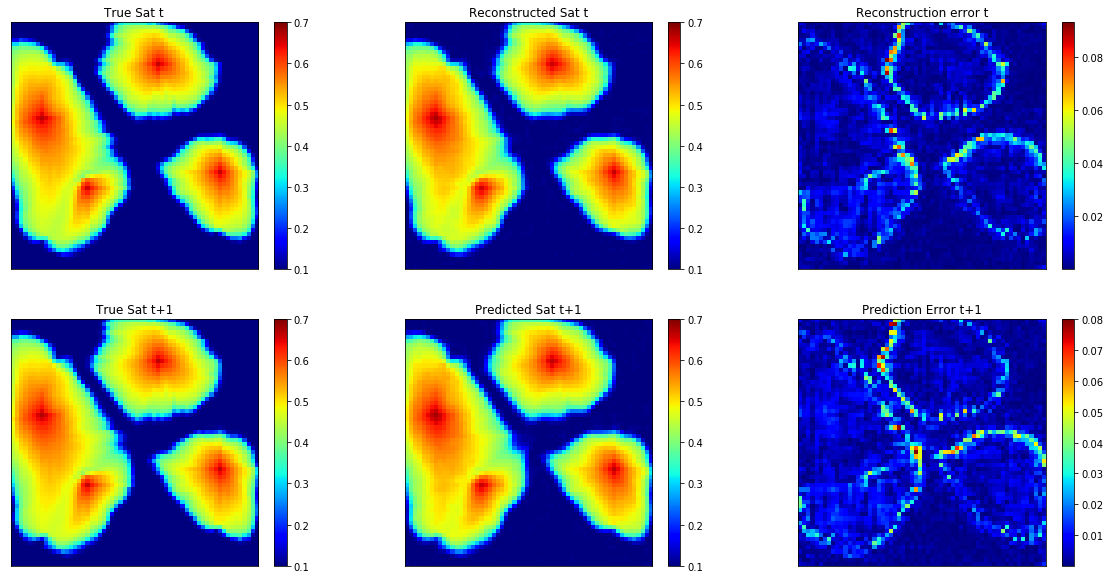

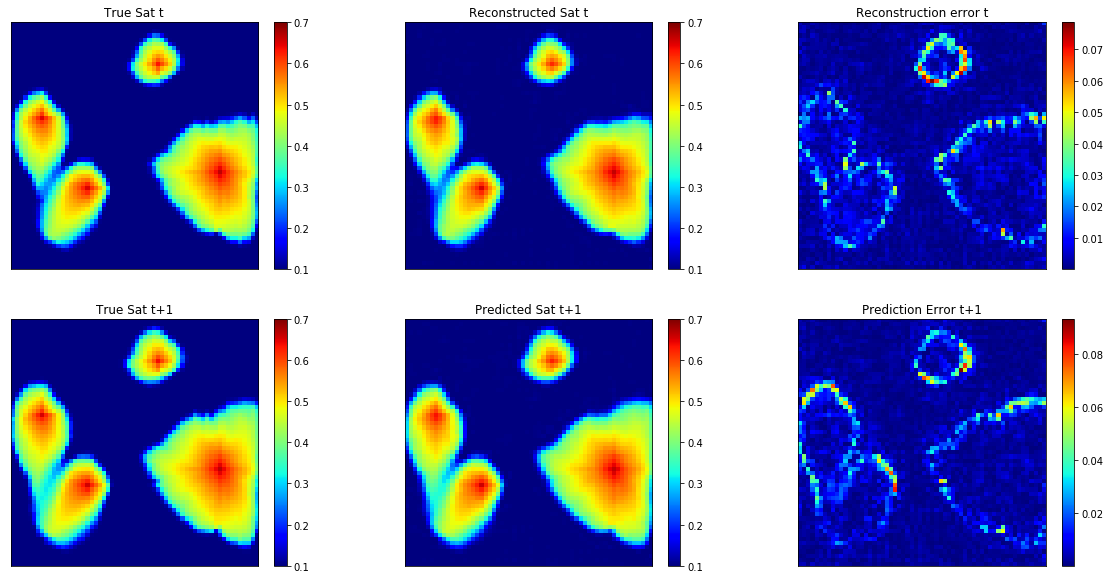

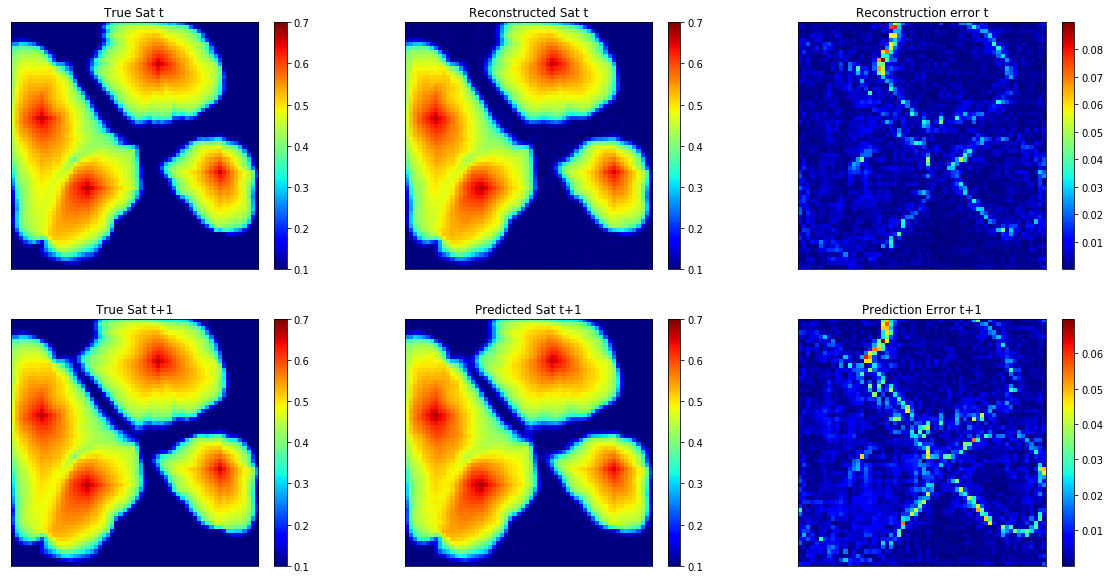

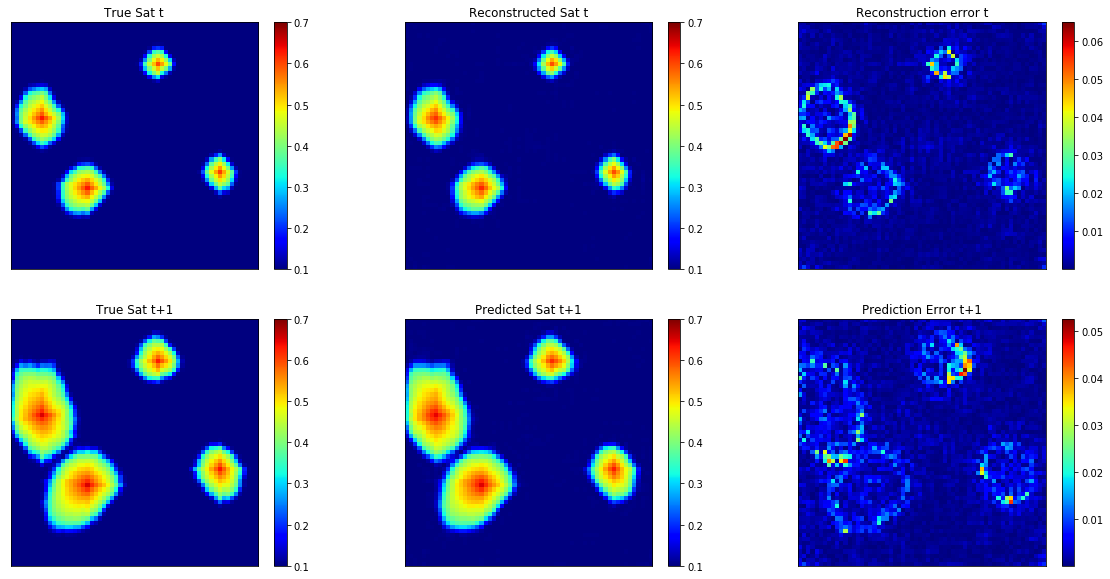

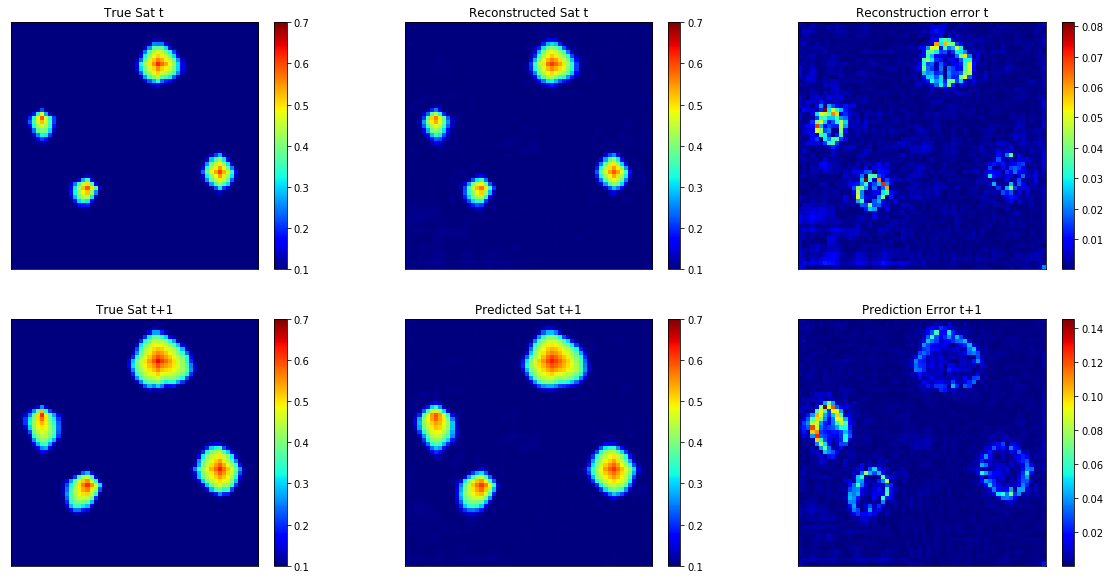

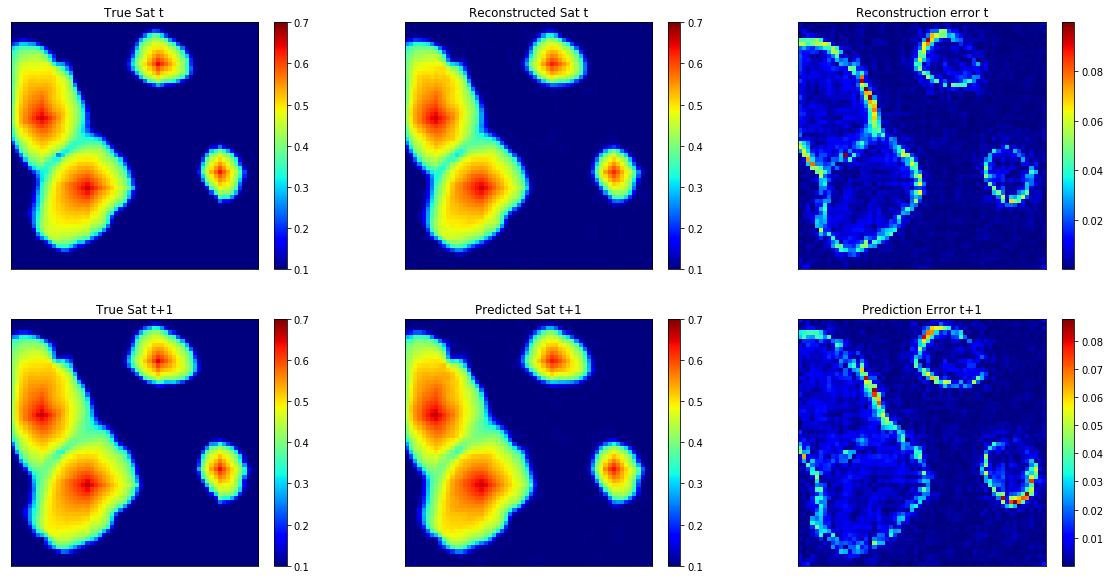

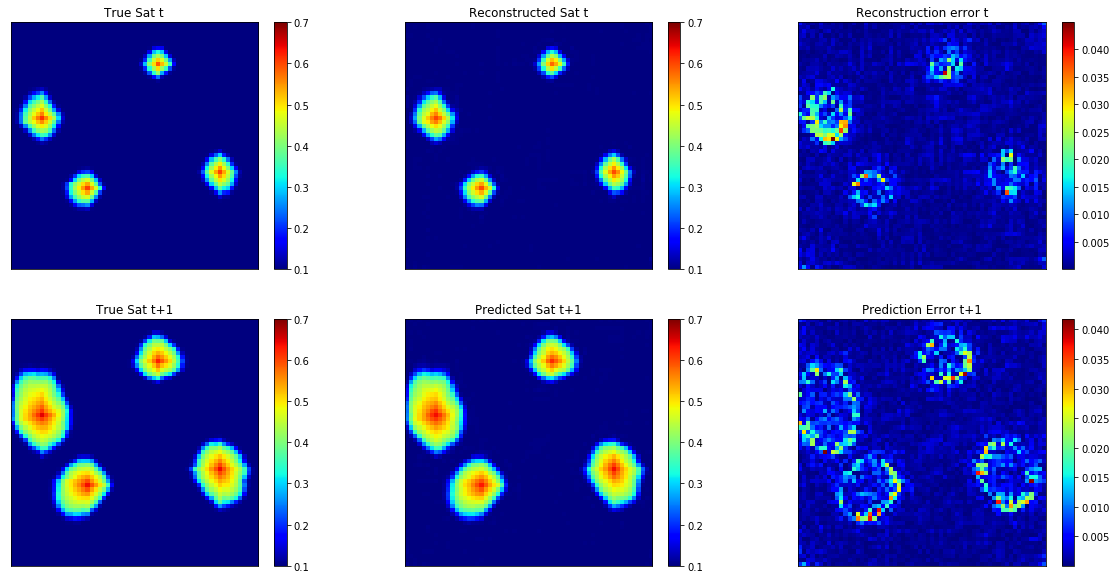

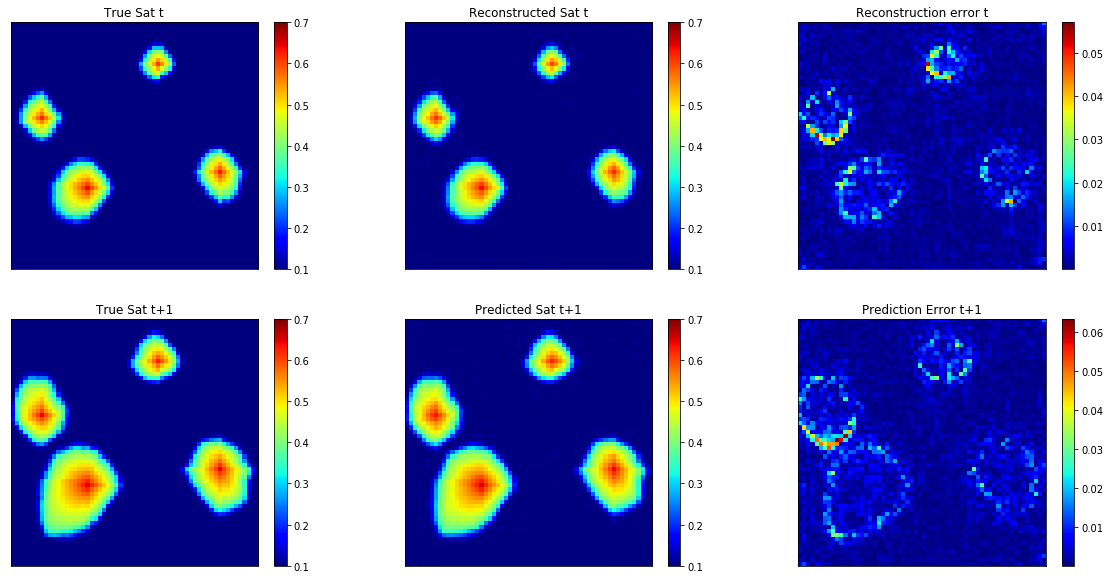

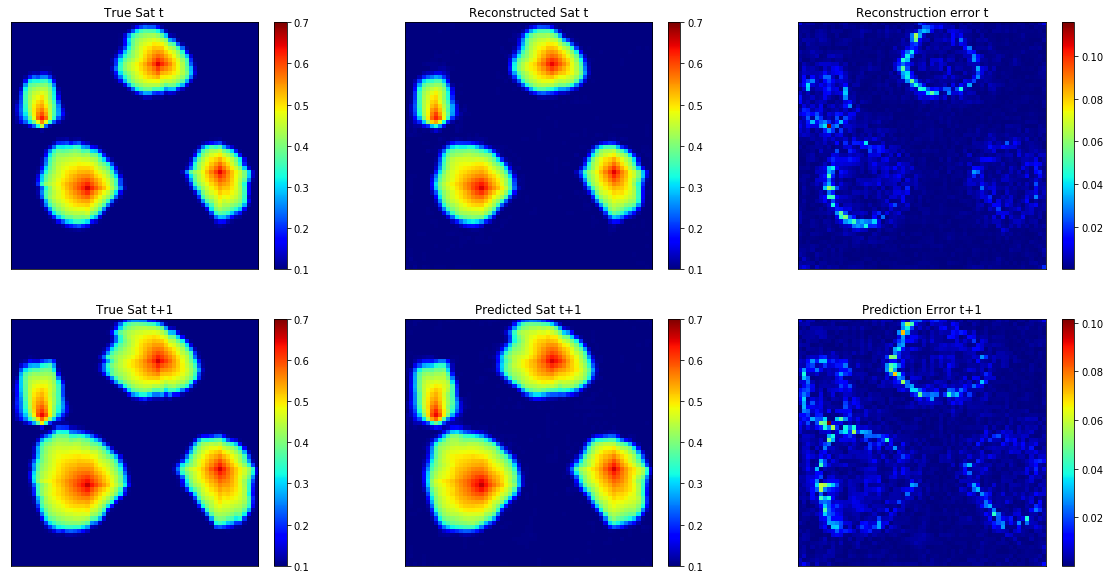

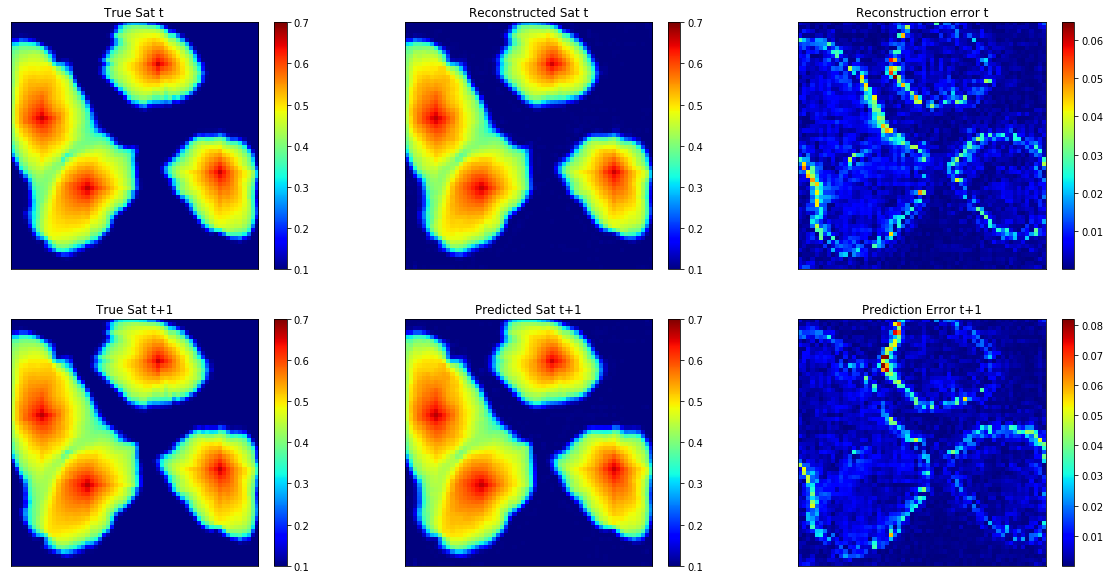

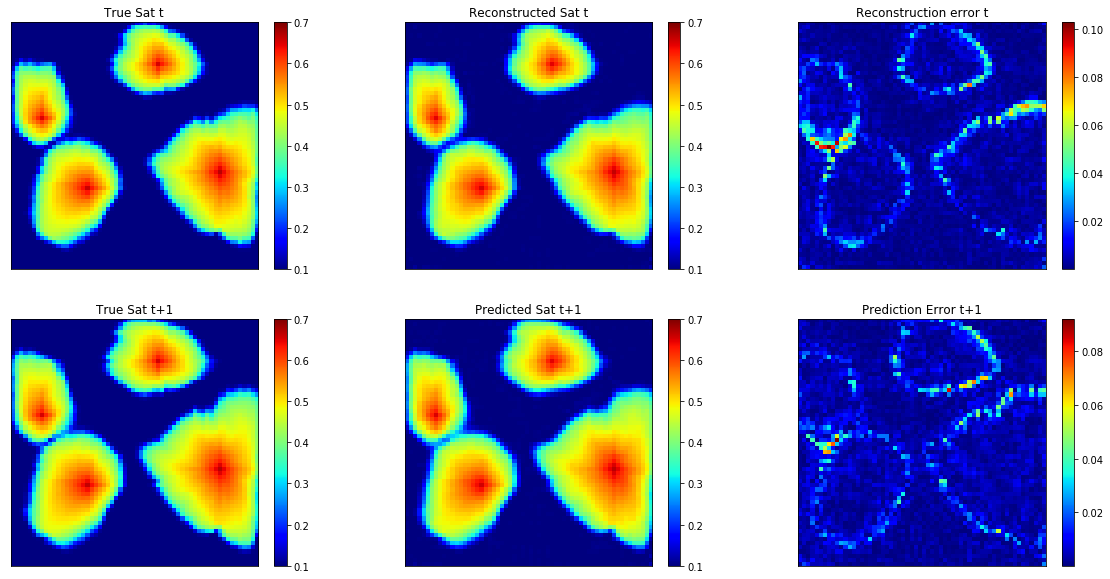

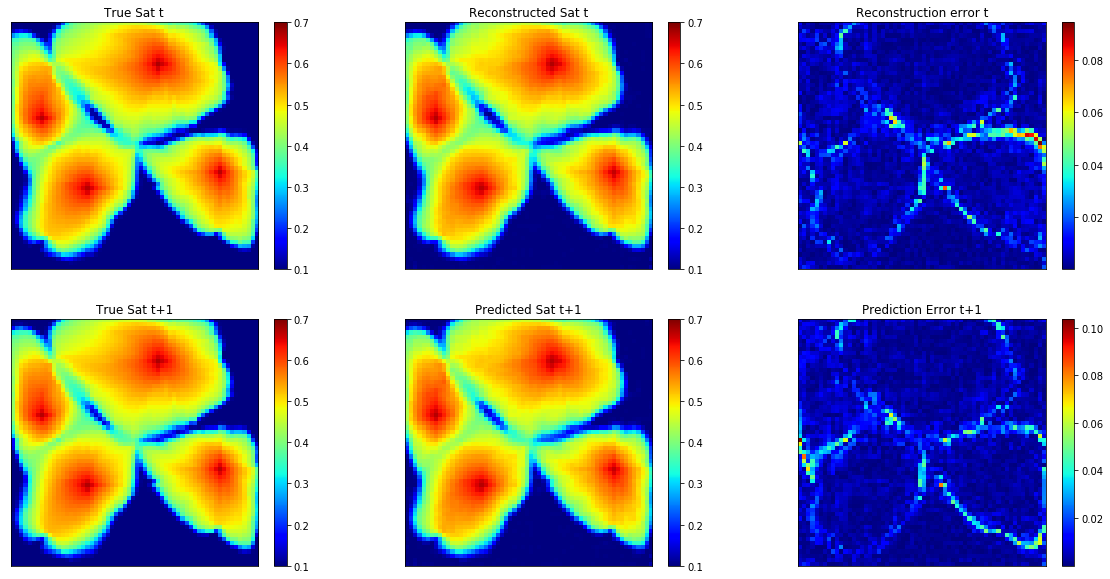

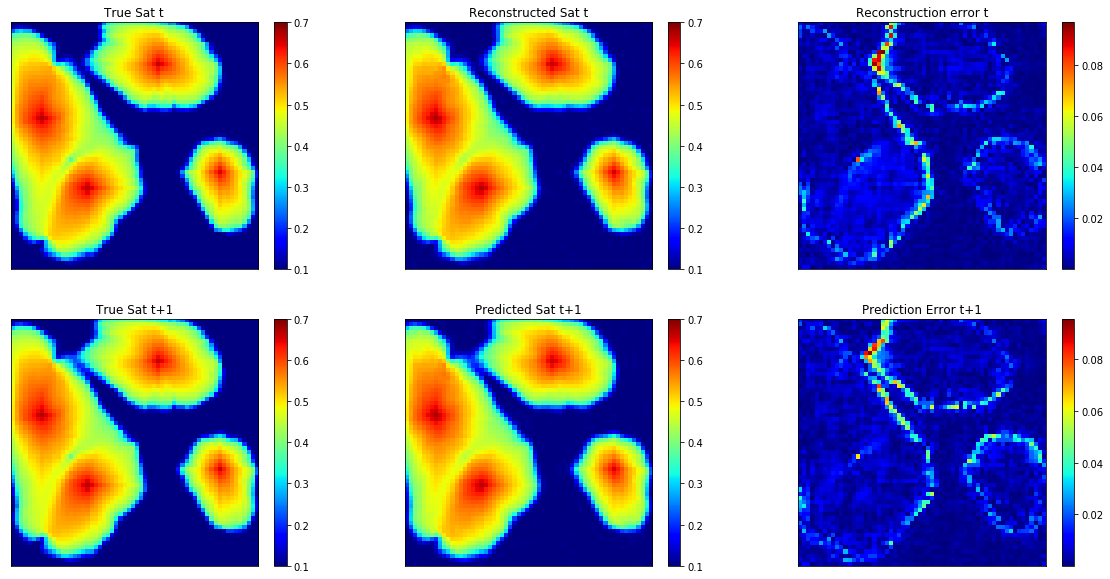

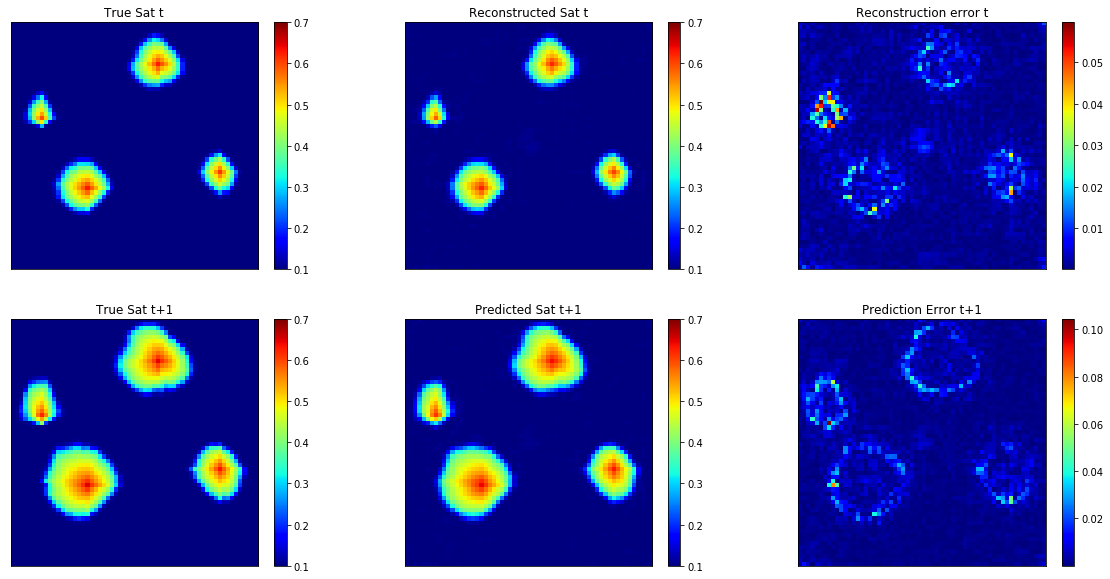

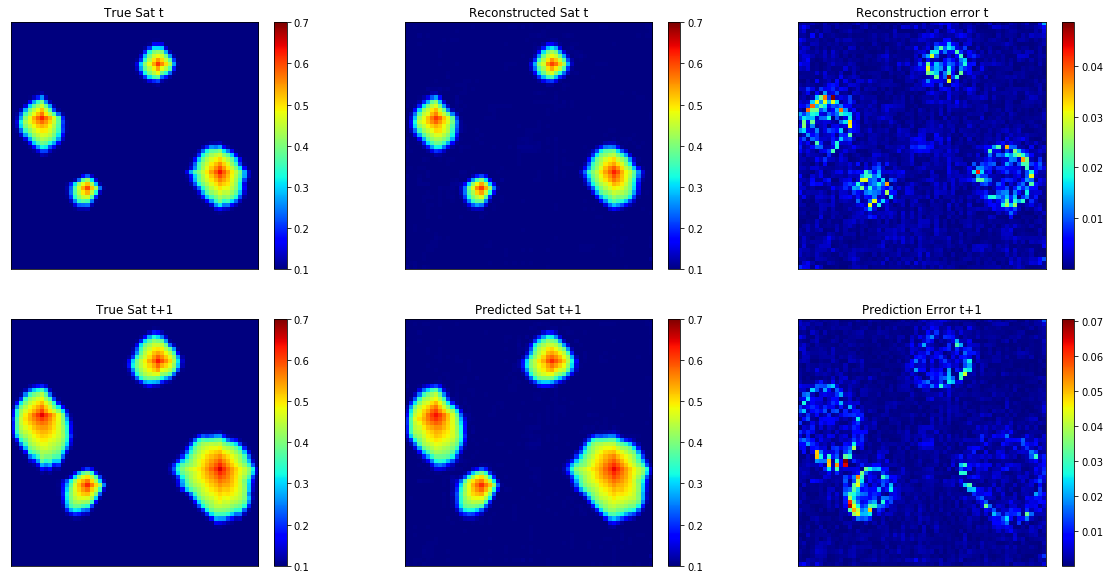

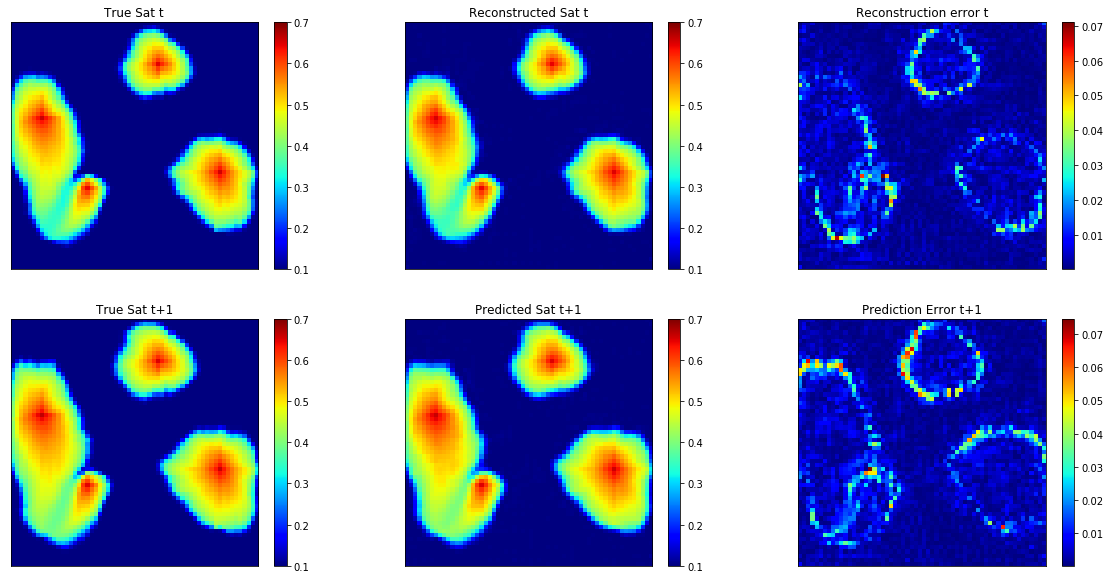

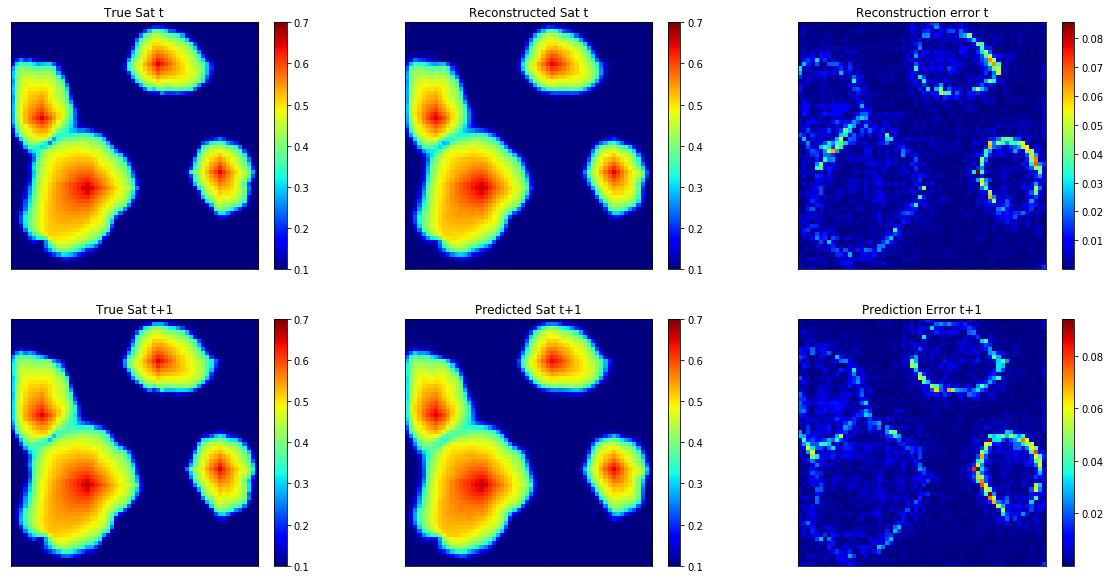

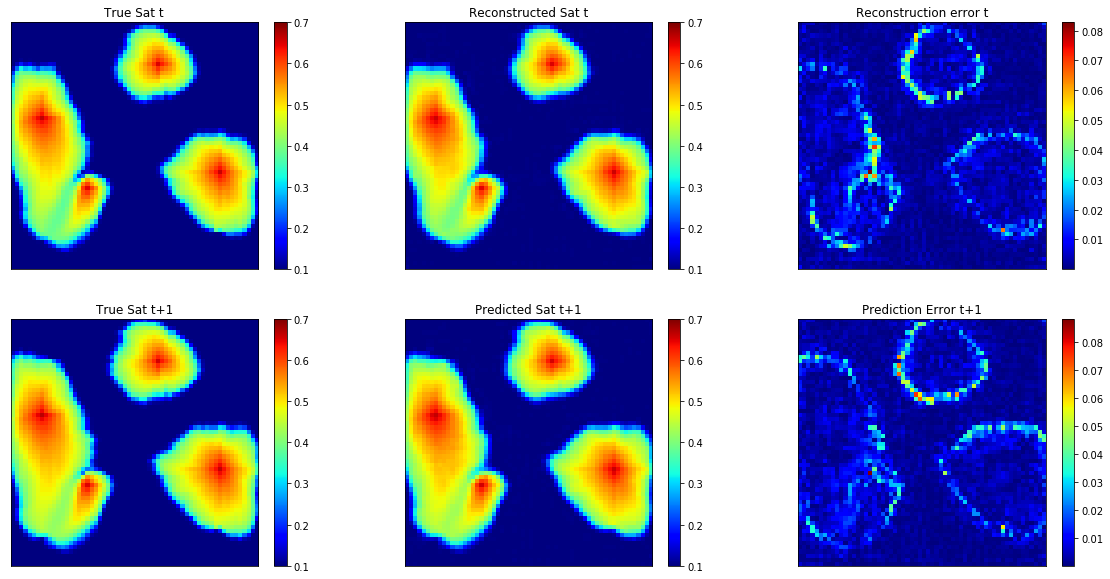

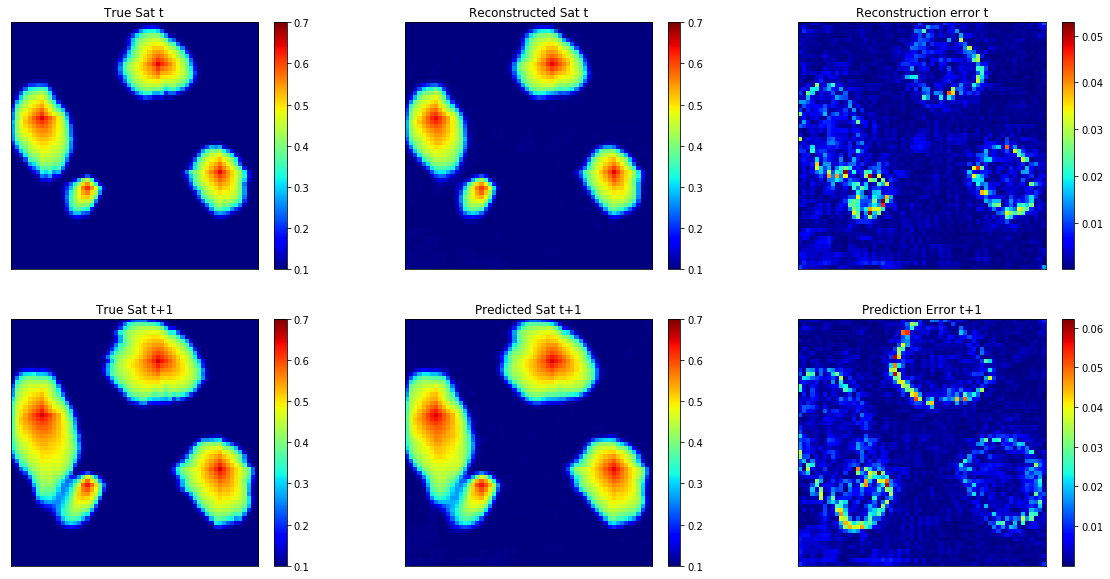

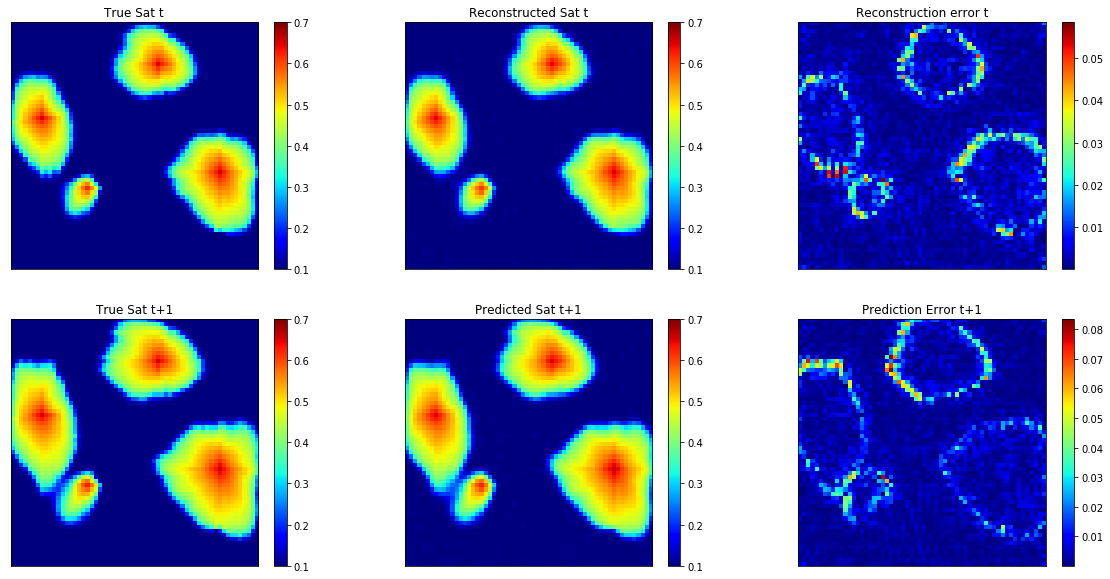

In [16]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Sat t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec[k, :, :, 0] - state_t_eval[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Sat t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred[k, :, :, 0] - state_t1_eval[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

In [83]:
p_max = 370*14.5038
p_min = 280*14.5038
p_diff = p_max - p_min

state_t_eval_plot = state_t_eval * p_diff + p_min
state_t_rec_plot = state_t_rec * p_diff + p_min
state_t1_eval_plot = state_t1_eval * p_diff + p_min
state_t1_pred_plot = state_t1_pred * p_diff + p_min

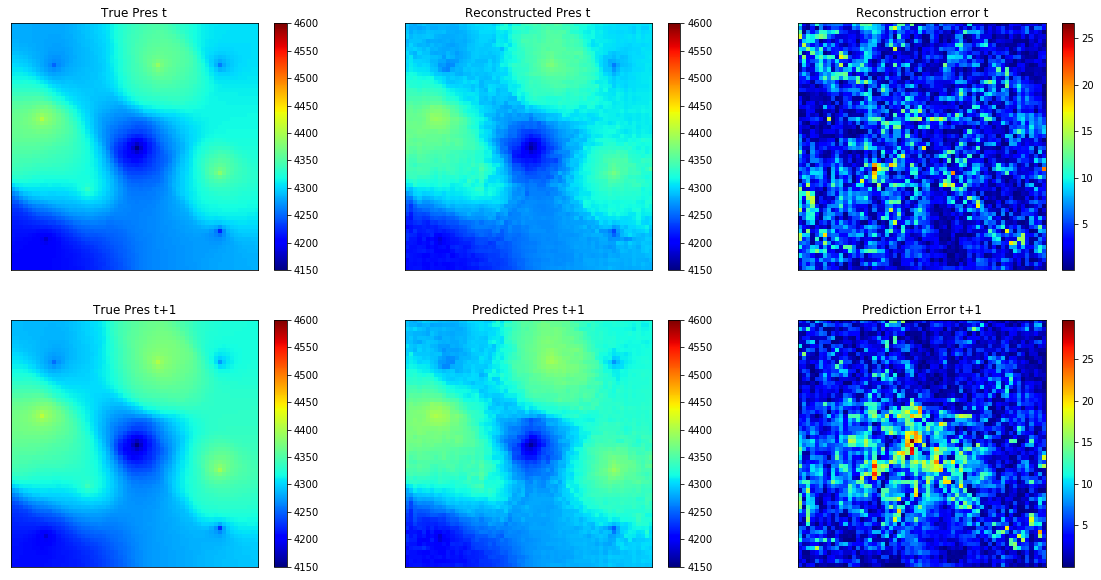

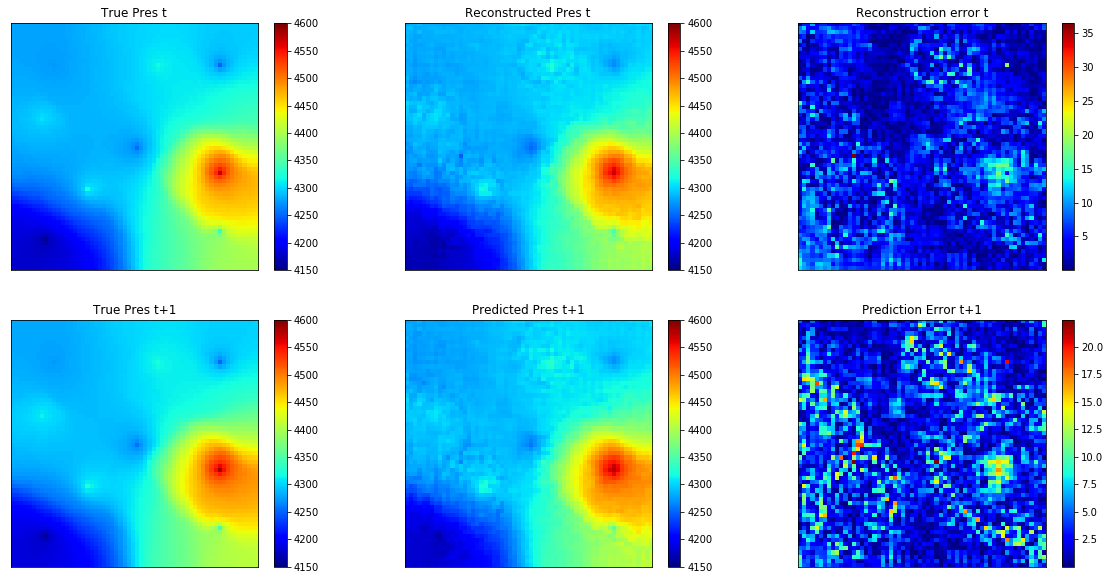

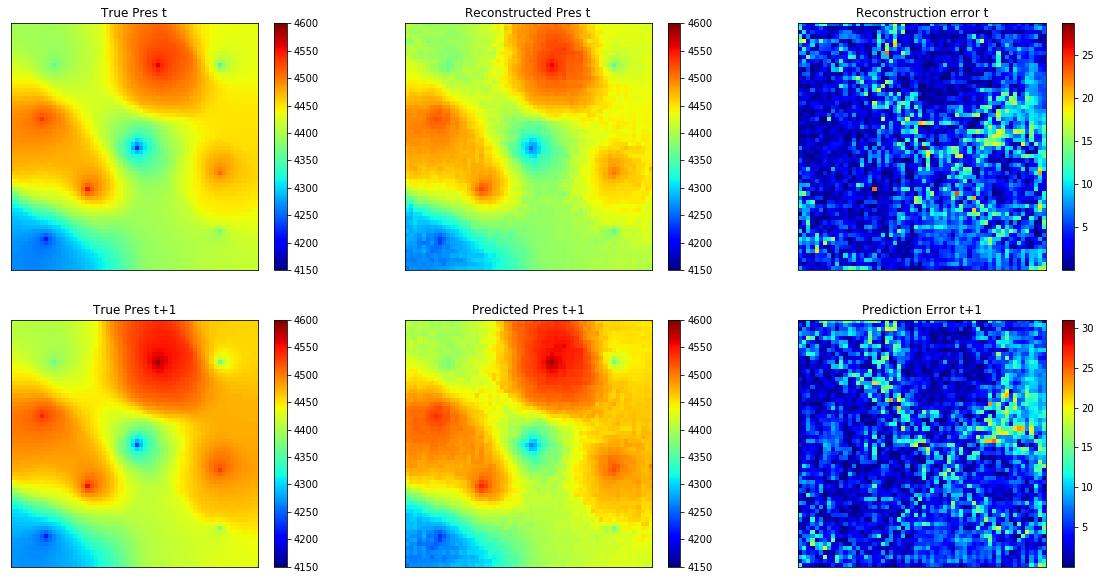

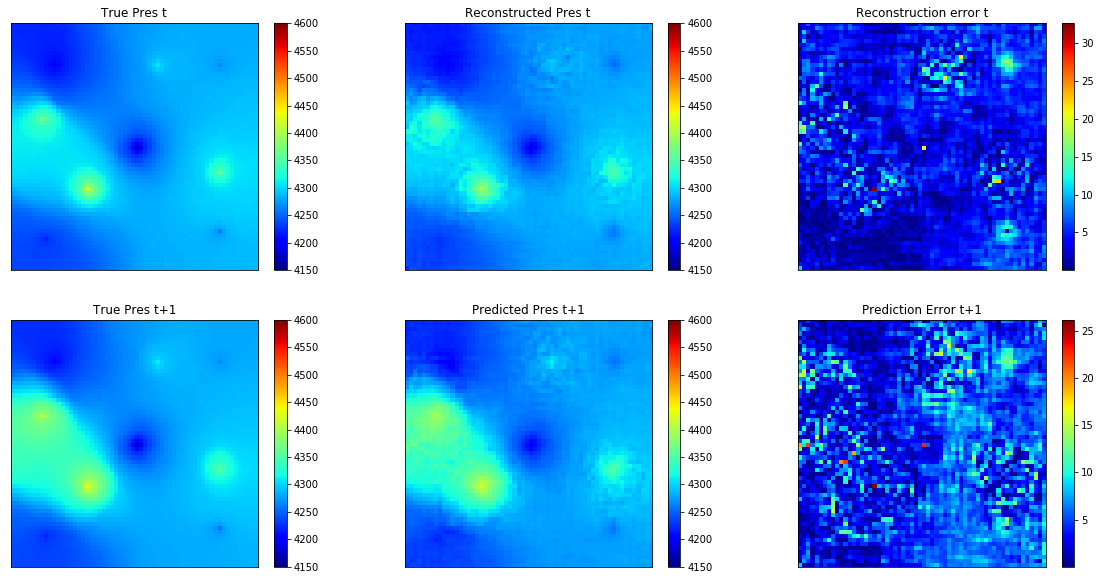

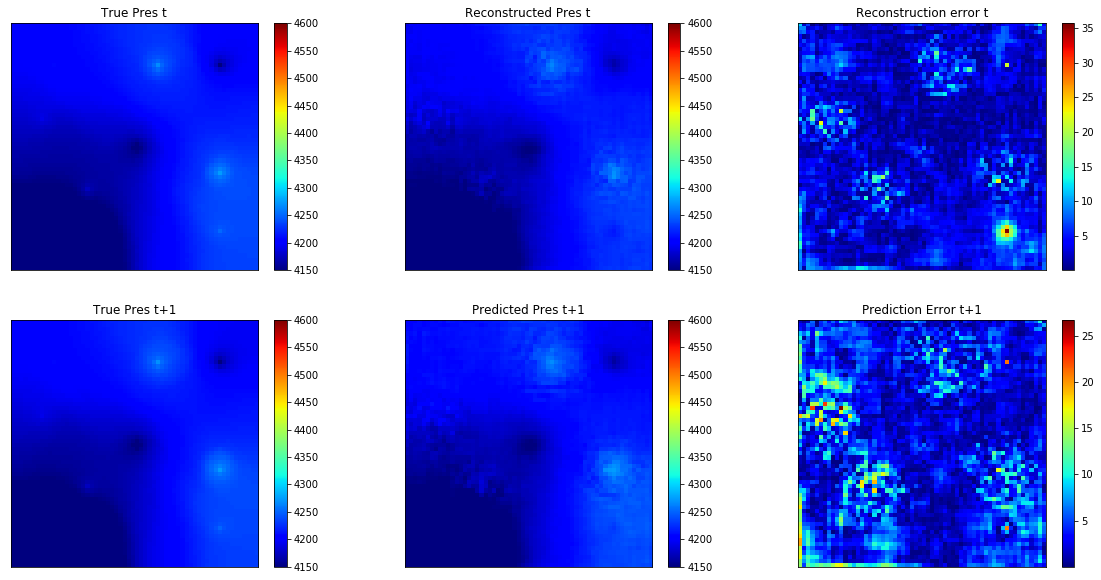

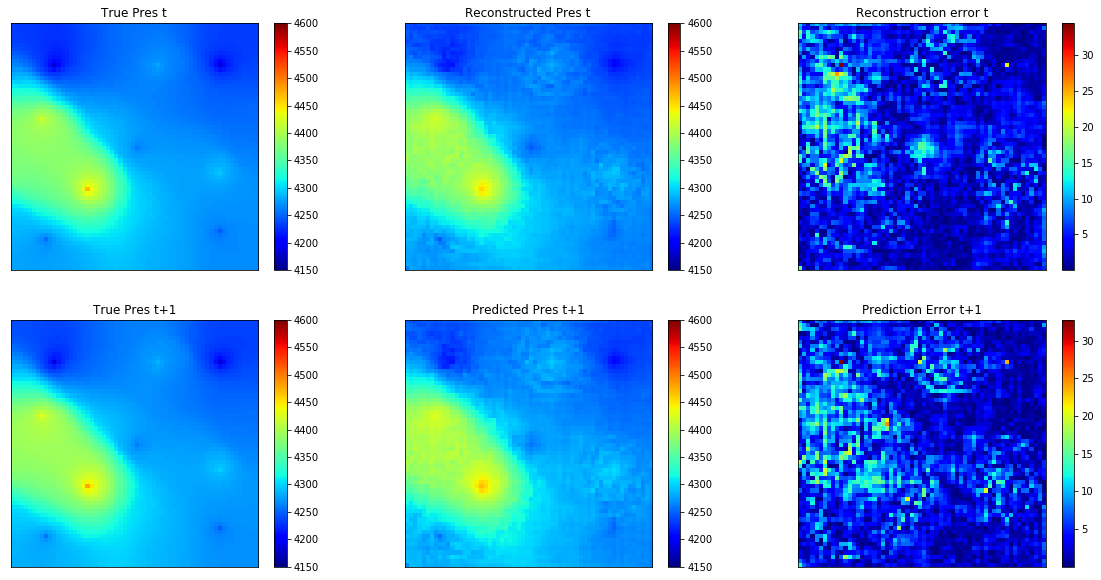

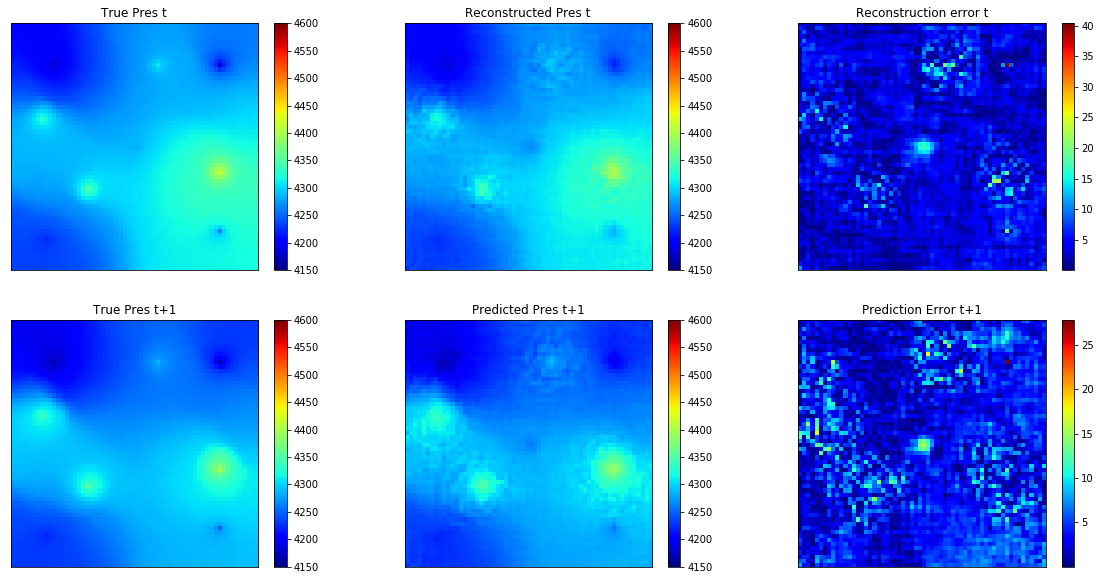

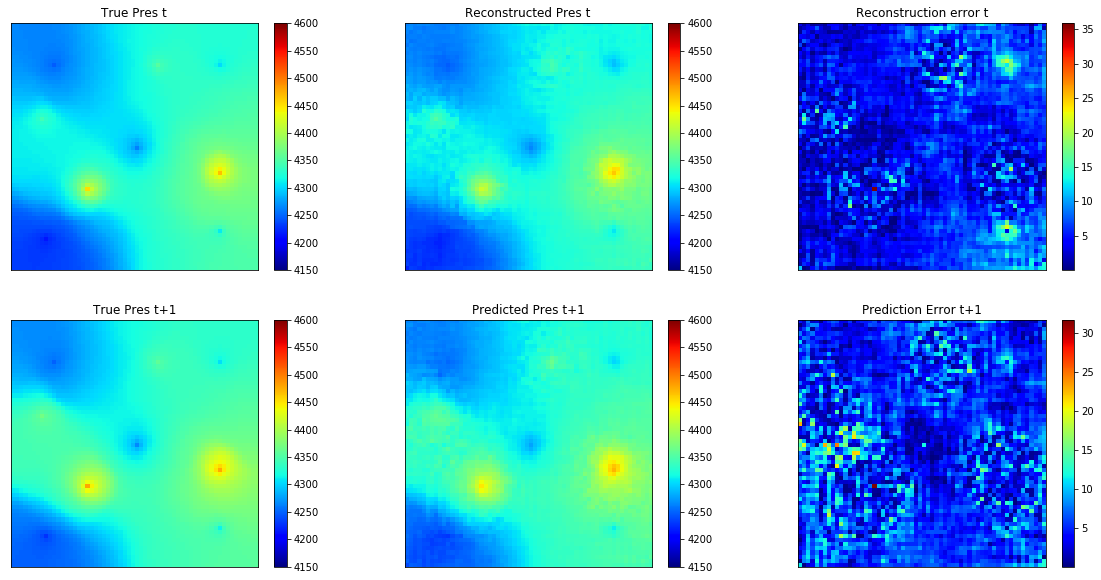

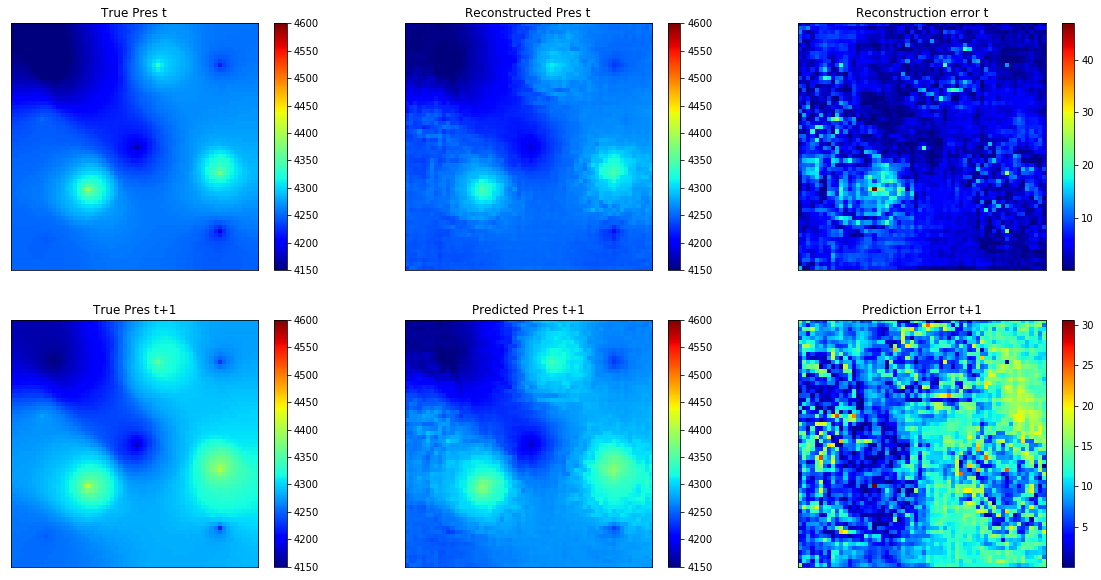

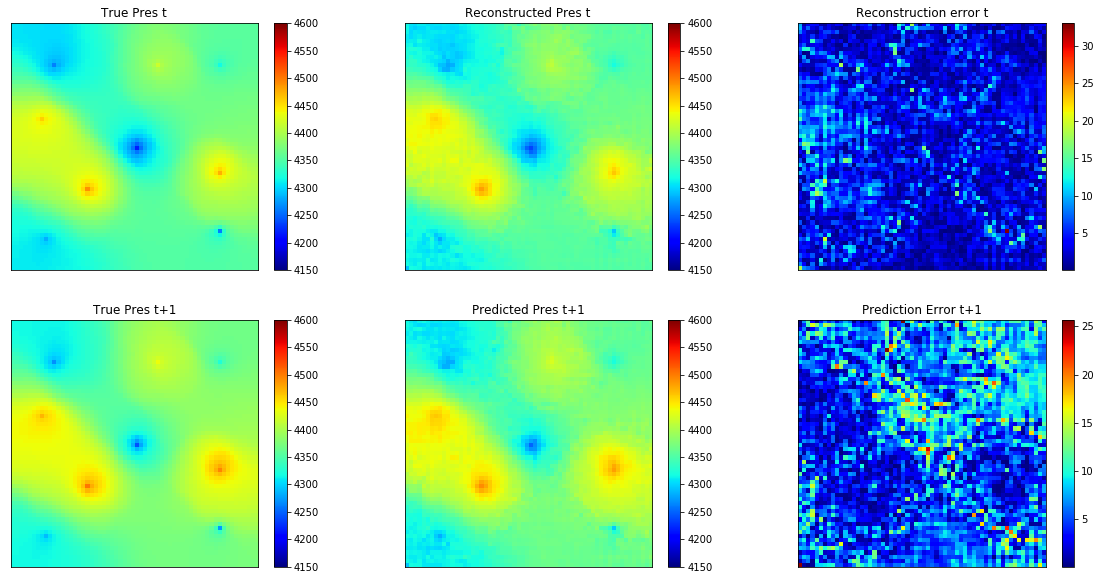

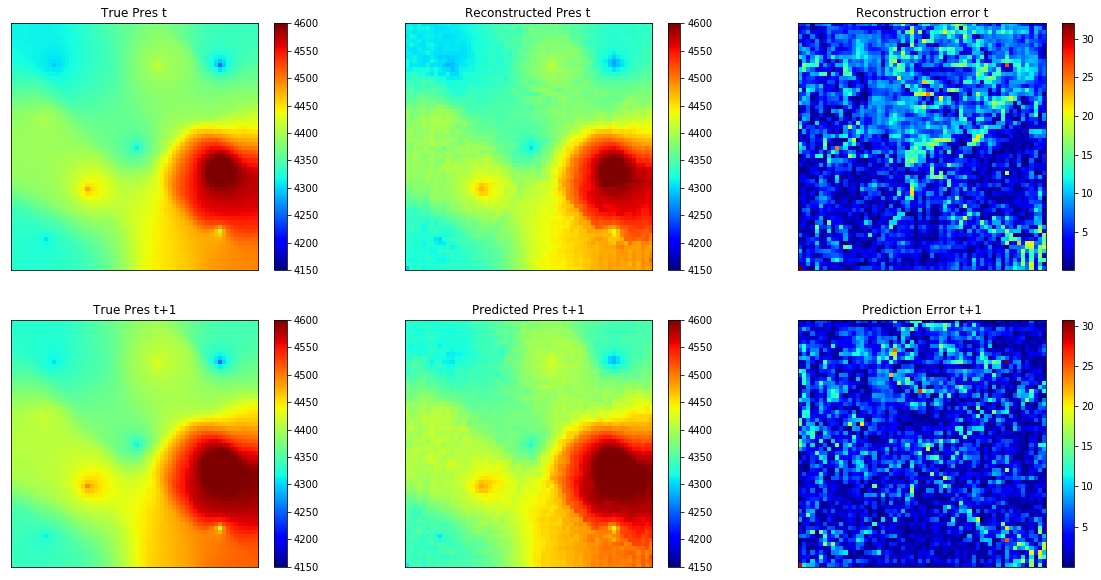

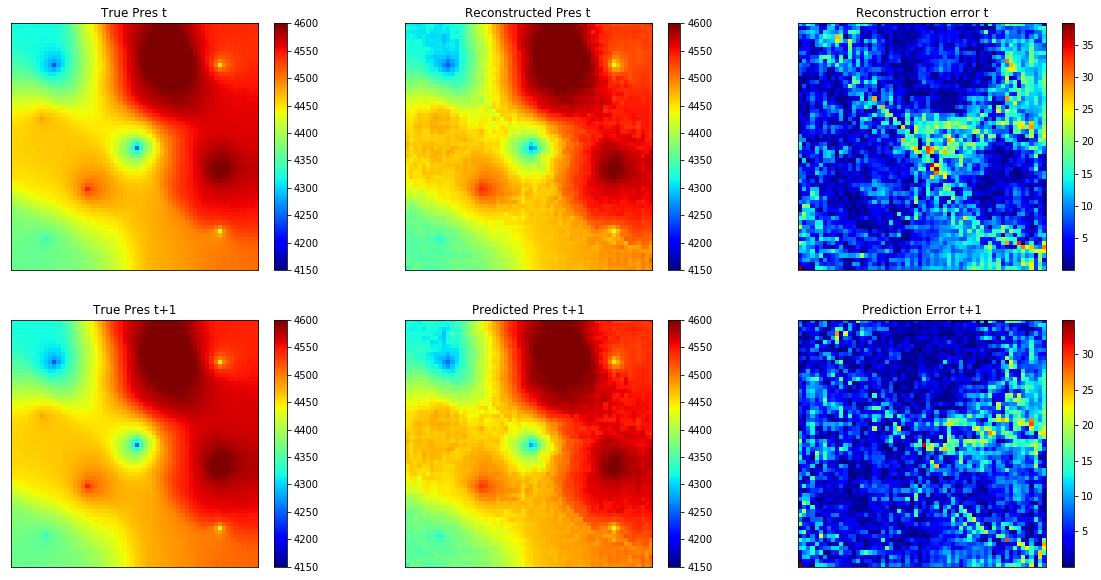

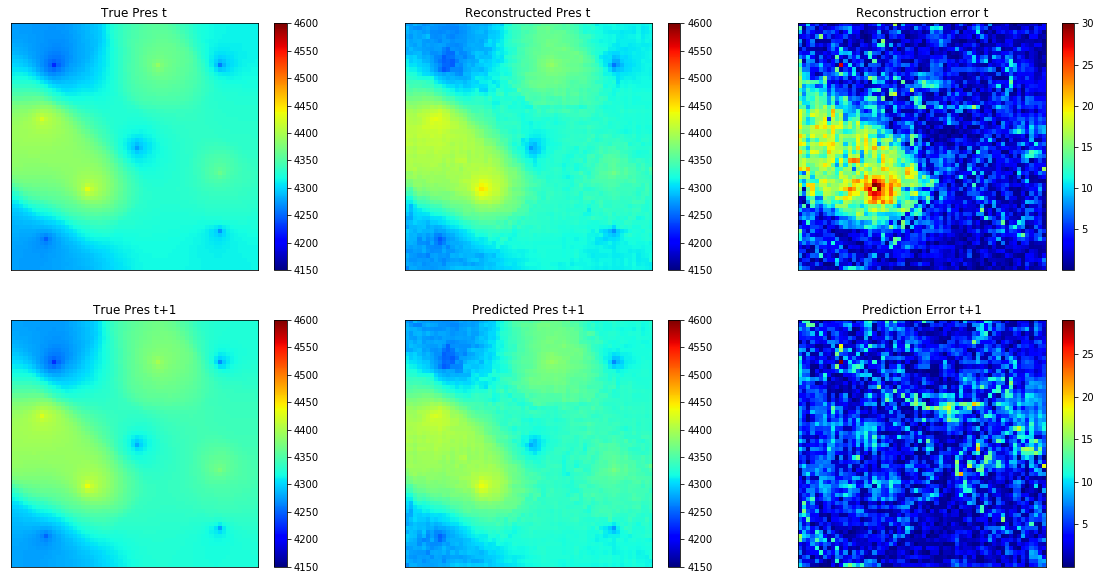

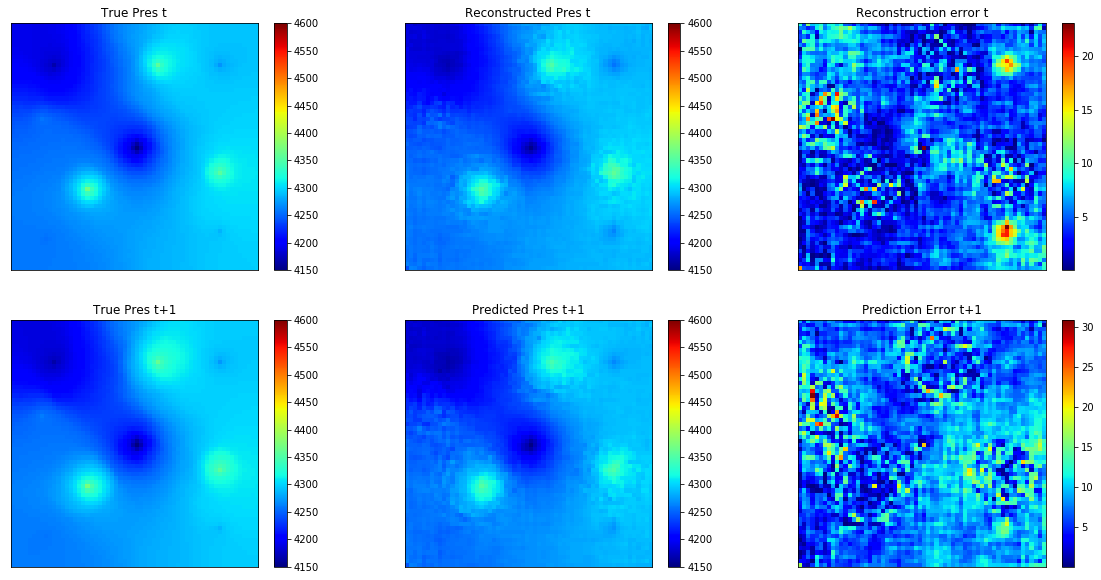

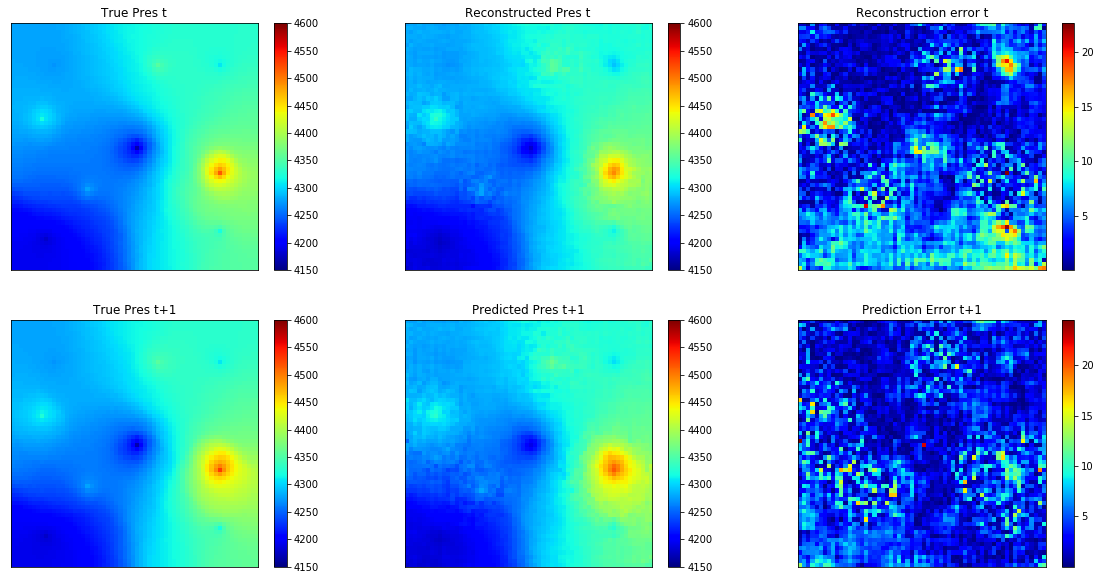

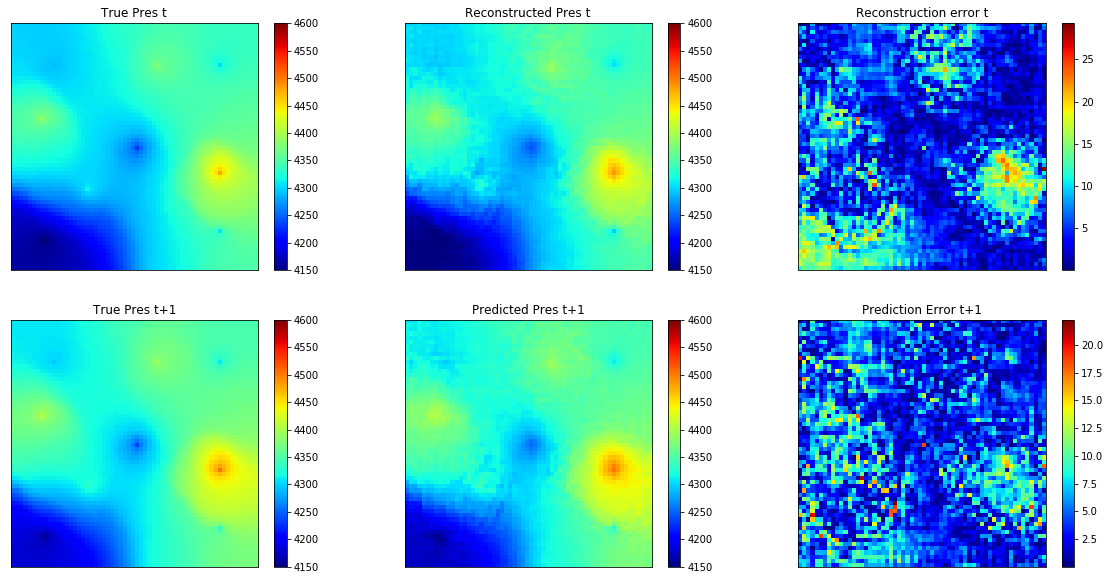

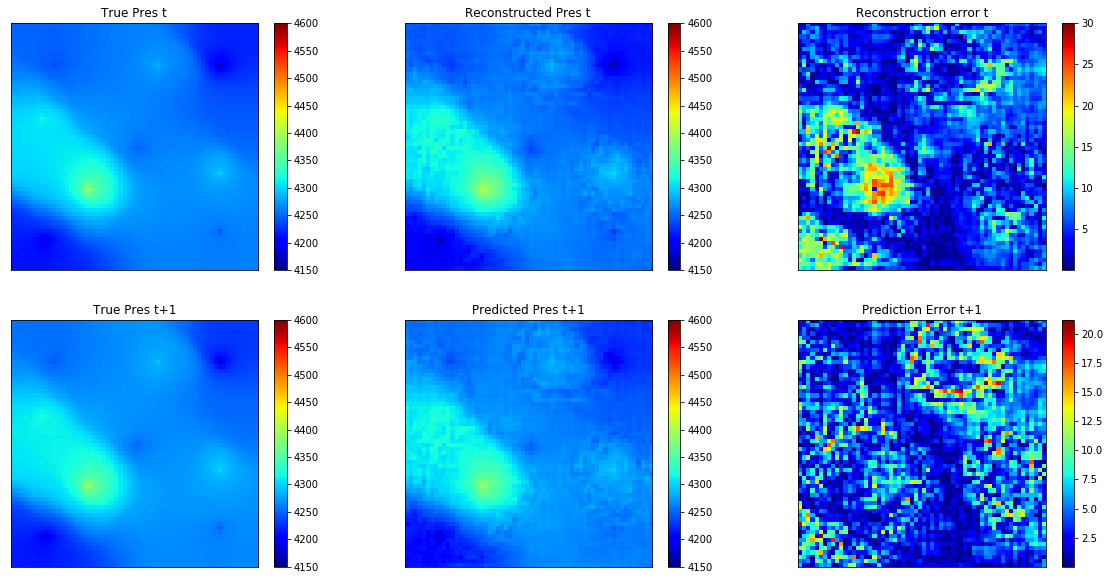

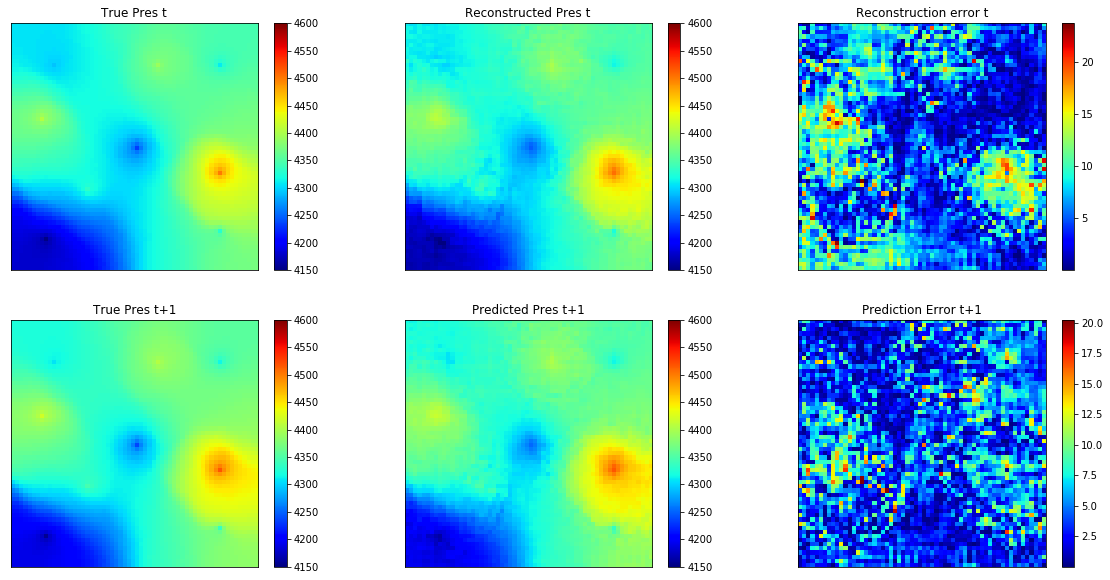

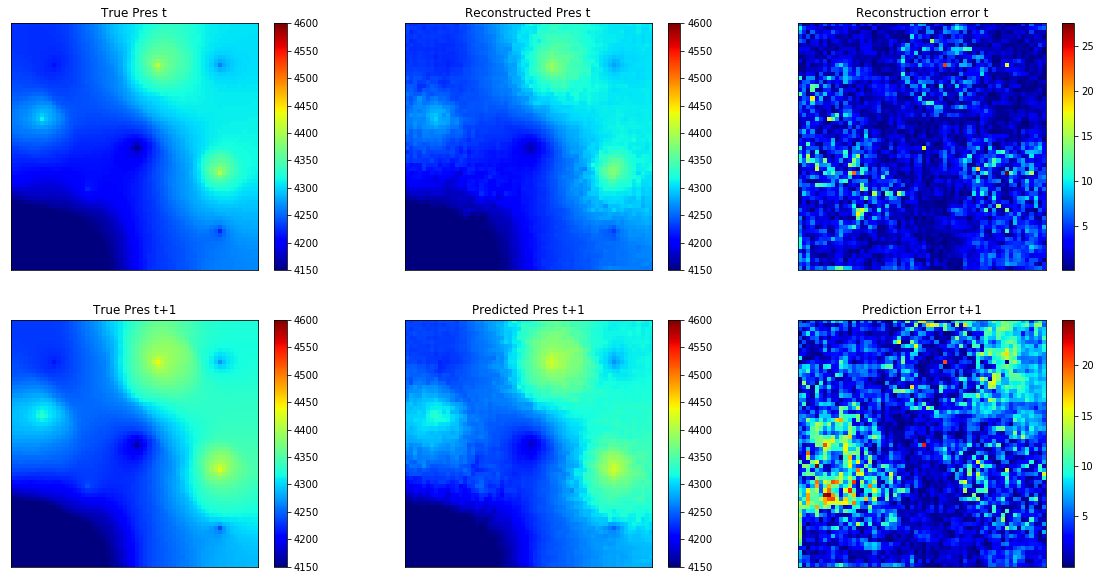

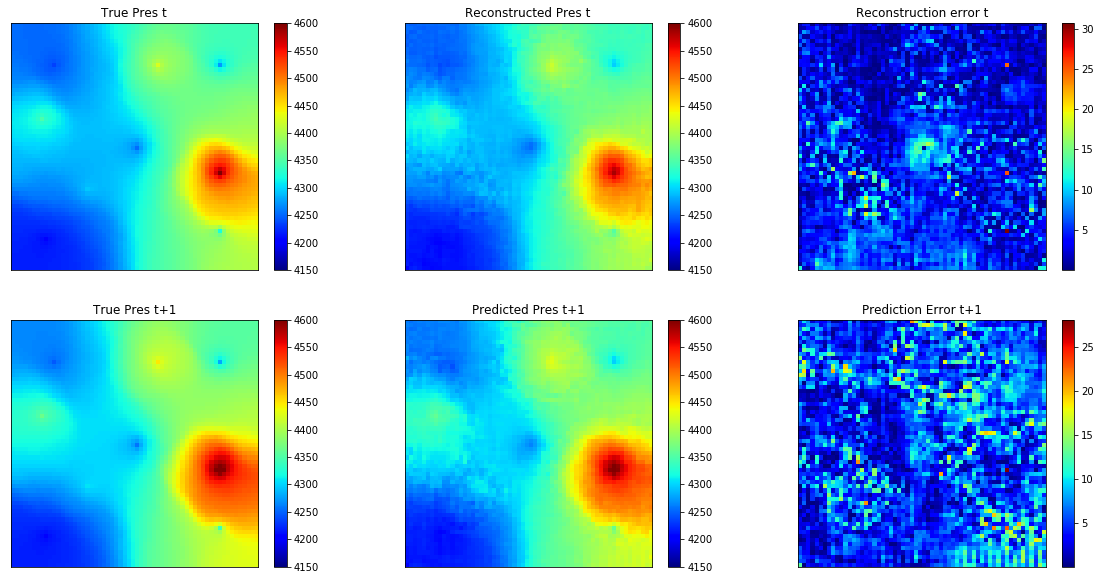

In [85]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Pres t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec_plot[k, :, :, 1] - state_t_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred_plot[k, :, :, 1])
    plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Pres t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred_plot[k, :, :, 1] - state_t1_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

## Sequential prediction

In [26]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = np.array(hf_r.get('sat'))
pres = np.array(hf_r.get('pres'))
hf_r.close()

In [27]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = np.array(hf_r.get('bhp'))
rate0 = np.array(hf_r.get('rate'))
hf_r.close()
# bhp -= 0.45

In [28]:
bhp = np.concatenate((bhp0,rate0),axis=1)
print(bhp.shape)

(400, 9)


In [29]:
sat = sat.T.reshape((400, 100, 3600))
pres = pres.T.reshape((400, 100, 3600))

In [30]:
ind_case = [1, 101, 201, 301]

In [47]:
num_case = 4
num_tstep = 10
sat_pred = np.zeros((num_case, num_tstep, 60, 60, 1))
pres_pred = np.zeros((num_case, num_tstep, 60, 60, 1))

In [33]:
bhp_seq = bhp[ind_case, :]

In [37]:
sat_t_seq = sat[ind_case, 4, :].reshape((num_case, 60, 60, 1)) # 4 here is the 4th timestep, t = 8
pres_t_seq = pres[ind_case, 4, :].reshape((num_case, 60, 60, 1))

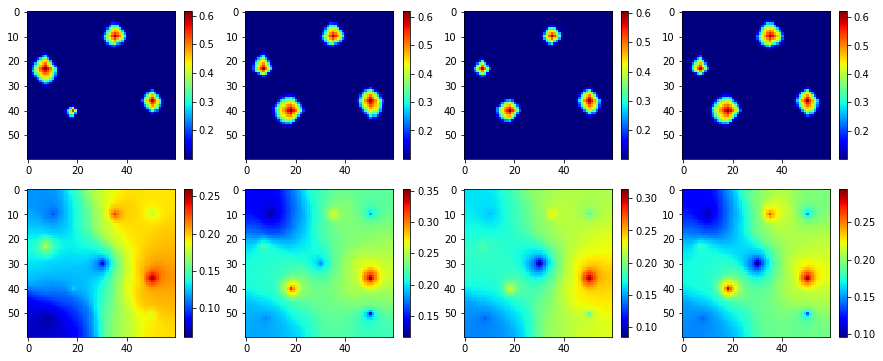

In [63]:
plt.figure(figsize=(15,6))
for k in range(num_case):
    plt.subplot(2,4,k+1)
    plt.imshow(sat_t_seq[k, :, :, 0])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(2,4,k+5)
    plt.imshow(pres_t_seq[k, :, :, 0])
    plt.colorbar(fraction=0.046)
plt.show()

In [40]:
print(sat_t_seq.shape)
print(sat_pred.shape)
print(pres_t_seq.shape)
print(pres_pred.shape)
print(bhp_seq.shape)

(4, 60, 60, 1)
(4, 10, 60, 60)
(4, 60, 60, 1)
(4, 10, 60, 60)
(4, 9)


In [69]:
state_t_seq = np.concatenate((sat_t_seq, pres_t_seq),axis=3)
state_pred = np.concatenate((sat_pred, pres_pred),axis=4)
print(state_t_seq.shape)
print(state_pred.shape)

(4, 60, 60, 2)
(4, 10, 60, 60, 2)


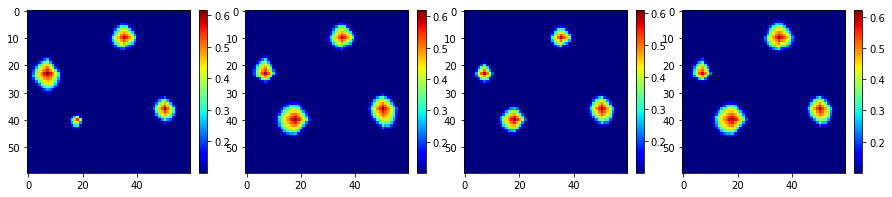

In [71]:
plt.figure(figsize=(15,3))
for k in range(num_case):
    plt.subplot(1,4,k+1)
    plt.imshow(state_t_seq[k, :, :, 0])
    plt.colorbar(fraction=0.046)
plt.show()

In [72]:
for i_tstep in range(10):
    state_pred[:, i_tstep, ...] = state_t_seq.copy()
    [_, state_t1_seq] = e2c_model.predict([state_t_seq, bhp_seq])
    state_t_seq = state_t1_seq.copy()

In [73]:
t_steps = list(np.arange(4,104,10))
print(t_steps)
# num_tstep = len(t_steps)

[4, 14, 24, 34, 44, 54, 64, 74, 84, 94]


In [74]:
print(sat.shape)
print(pres.shape)
# print(state.shape)

(400, 100, 3600)
(400, 100, 3600)


In [75]:
sat_seq_true = sat[ind_case, ...]
sat_seq_true = sat_seq_true[:, list(np.arange(4,104,10)), :]
print(sat_seq_true.shape)

pres_seq_true = pres[ind_case, ...]
pres_seq_true = pres_seq_true[:, list(np.arange(4,104,10)), :]
print(pres_seq_true.shape)
state_seq_true = np.zeros((4,10,3600,2))
state_seq_true[:,:,:,0] = sat_seq_true
state_seq_true[:,:,:,1] = pres_seq_true
print(state_seq_true.shape)

(4, 10, 3600)
(4, 10, 3600)
(4, 10, 3600, 2)


Case num: 1


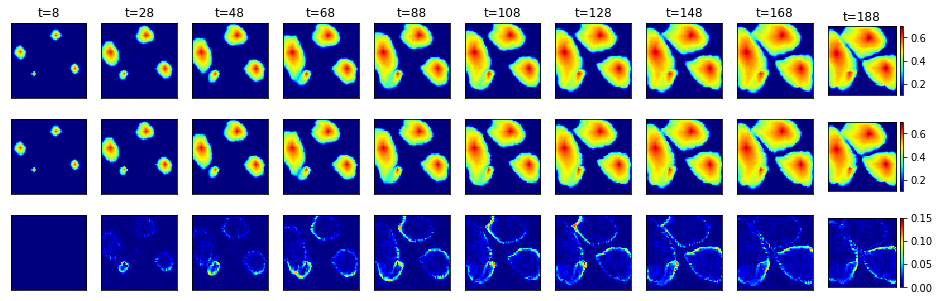

Case num: 101


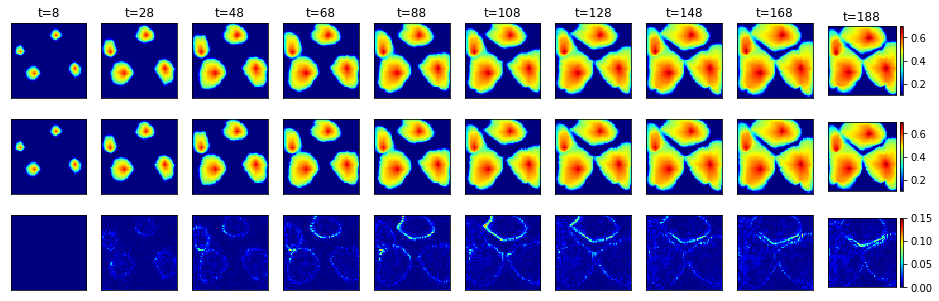

Case num: 201


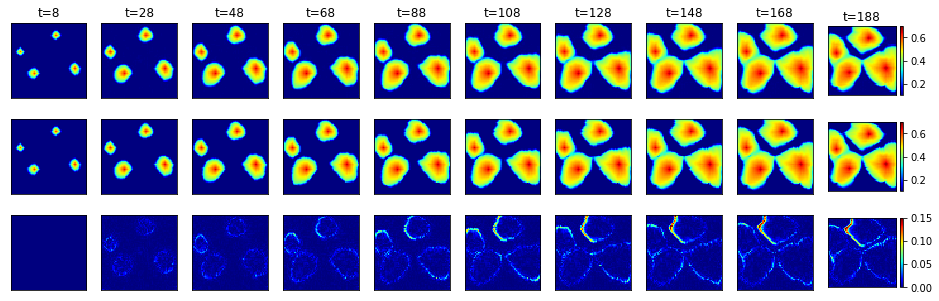

Case num: 301


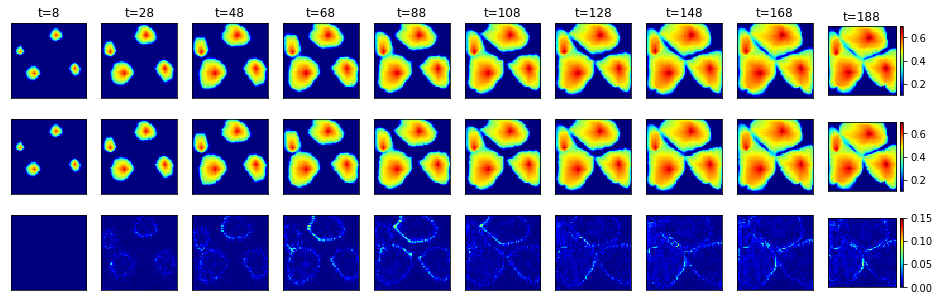

In [89]:
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)):
        plt.subplot(3, num_tstep, i_tstep+1)
        plt.imshow(state_pred[k, i_tstep, :,:, 0])
        plt.title('t=%d'%(t_steps[i_tstep]*2))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep, i_tstep+1+num_tstep)
        plt.imshow(state_seq_true[k, i_tstep, :, 0].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep, i_tstep+1+2*num_tstep)
        plt.imshow(np.fabs(state_seq_true[k, i_tstep, :, 0].reshape((60,60)) - state_pred[k, i_tstep, :,:, 0]))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [86]:
state_pred_plot = state_pred[:, :, :, :, 1] * p_diff + p_min
state_seq_true_plot = state_seq_true[:, :, :, 1] * p_diff + p_min

Case num: 1


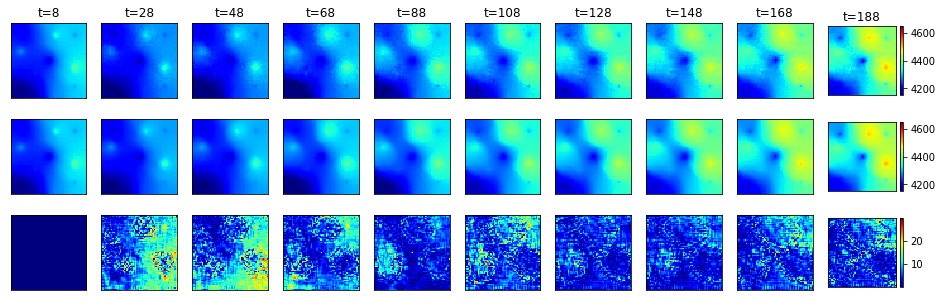

Case num: 101


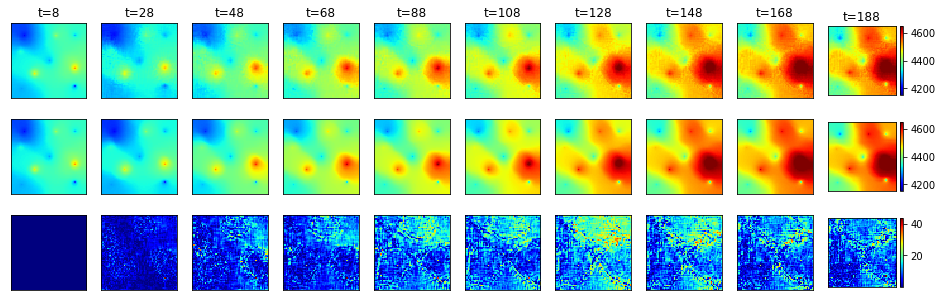

Case num: 201


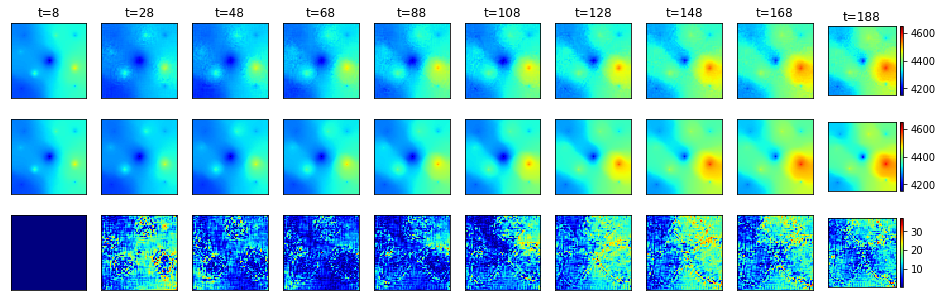

Case num: 301


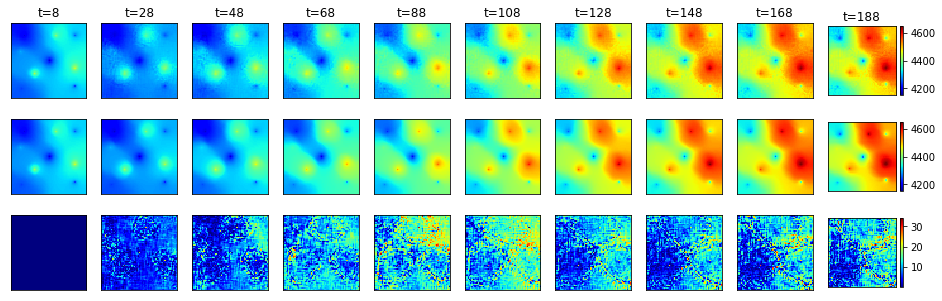

In [91]:
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)):
        plt.subplot(3, num_tstep, i_tstep+1)
        plt.imshow(state_pred_plot[k, i_tstep, :, :])
        plt.title('t=%d'%(t_steps[i_tstep]*2))
        plt.xticks([])
        plt.yticks([])
        plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep, i_tstep+1+num_tstep)
        plt.imshow(state_seq_true_plot[k, i_tstep, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep, i_tstep+1+2*num_tstep)
        plt.imshow(np.fabs(state_seq_true_plot[k, i_tstep, :].reshape((60,60)) - state_pred_plot[k, i_tstep, :,:]))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()